In [1]:
import os
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("noureldinomran/egyptian-stock-exchange-egx30")
files = os.listdir(path)
print("Files in dataset:", files)

egx30_path = os.path.join(path, "EGX30")
files_inside_egx30 = os.listdir(egx30_path)
print("Files inside EGX30 folder:", files_inside_egx30)

sample_stock_path = os.path.join(egx30_path, "COMI")
files_inside_stock = os.listdir(sample_stock_path)
print("Files inside COMI folder:", files_inside_stock)

dfs = []

for stock_symbol in os.listdir(egx30_path):
    stock_folder = os.path.join(egx30_path, stock_symbol)

    # Check if the folder contains a CSV file
    csv_files = [f for f in os.listdir(stock_folder) if f.endswith(".csv")]

    if len(csv_files) > 0:
        csv_path = os.path.join(stock_folder, csv_files[0])  # There should be only one CSV file per stock

        # Load the stock data
        df = pd.read_csv(csv_path)

        # Convert Date to datetime
        df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y", errors='coerce')

        # Convert Volume to numeric (handling "M" and "K")
        def convert_volume(vol):
            if isinstance(vol, str):
                vol = vol.replace(',', '')
                if 'M' in vol:
                    return float(vol.replace('M', '')) * 1_000_000
                elif 'K' in vol:
                    return float(vol.replace('K', '')) * 1_000
            try:
                return float(vol)
            except ValueError:
                return None

        df['Vol.'] = df['Vol.'].astype(str).apply(convert_volume)
        df['Change %'] = df['Change %'].astype(str).str.replace(',', '').str.replace('%', '').astype(float, errors='ignore')
        df['Stock'] = stock_symbol
        dfs.append(df)


final_df = pd.concat(dfs, ignore_index=True)
print(final_df.head())

100%|██████████| 610k/610k [00:00<00:00, 92.4MB/s]

Extracting files...
Files in dataset: ['symbols.csv', 'EGX30']
Files inside EGX30 folder: ['ADIB', 'SKPC', 'EGCH', 'CIEB', 'ESRS', 'EAST', 'GBCO', 'ORHD', 'ORWE', 'EGTS', 'OCDI', 'CCAP', 'ABUK', 'HELI', 'SWDY', 'COMI', 'EKHOA', 'FWRY', 'BINV', 'ETEL', 'EFID', 'IRON', 'AMOC', 'JUFO', 'BTFH', 'CLHO', 'PHDC', 'CIRA', 'MFPC', 'HRHO', 'ISPH', 'ORAS', 'ALCN', 'EMFD', 'TMGH', 'EKHO', 'EFIH', 'MNHD', 'OIH']
Files inside COMI folder: ['COMI.csv']


        Date  Price   Open   High    Low      Vol.  Change % Stock
0 2023-08-09  24.92  25.00  25.20  24.60  485460.0     -0.04  ADIB
1 2023-08-08  24.93  24.80  25.19  24.58  302840.0      0.52  ADIB
2 2023-08-07  24.80  24.26  24.80  23.92  347380.0      3.20  ADIB
3 2023-08-06  24.03  23.77  24.33  23.65   88110.0      0.08  ADIB
4 2023-08-03  24.01  24.25  24.50  23.54   46000.0     -0.04  ADIB


In [2]:
df = final_df.copy()
df

,Date,Price,Open,High,Low,Vol.,Change %,Stock
0,2023-08-09,24.920,25.000,25.200,24.600,485460.0,-0.04,ADIB
1,2023-08-08,24.930,24.800,25.190,24.580,302840.0,0.52,ADIB
2,2023-08-07,24.800,24.260,24.800,23.920,347380.0,3.20,ADIB
3,2023-08-06,24.030,23.770,24.330,23.650,88110.0,0.08,ADIB
4,2023-08-03,24.010,24.250,24.500,23.540,46000.0,-0.04,ADIB
...,...,...,...,...,...,...,...,...
41151,2019-01-09,0.588,0.595,0.595,0.582,12330000.0,-1.18,OIH
41152,2019-01-08,0.595,0.584,0.601,0.581,47680000.0,1.71,OIH
41153,2019-01-06,0.585,0.578,0.590,0.578,10990000.0,0.86,OIH
41154,2019-01-03,0.580,0.580,0.584,0.577,6130000.0,-0.17,OIH


In [3]:
# Preprocessing
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

print("Old shape:", final_df.shape)
print("New shape:", df.shape)

Date         0
Price        0
Open         0
High         0
Low          0
Vol.        17
Change %     0
Stock        0
dtype: int64
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
Stock       0
dtype: int64
Old shape: (41156, 8)
New shape: (41139, 8)


In [4]:
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday  # 0 = Monday, 6 = Sunday

df['Price_lag1'] = df['Price'].shift(1) # previous day's closing price
df['MA_7'] = df['Price'].rolling(window=7).mean()  # 7-day moving average
df['MA_30'] = df['Price'].rolling(window=30).mean()  # 30-day moving average
df['Daily_Return'] = df['Price'].pct_change() * 100

# rolling standard deviation of daily returns
df['Volatility_7'] = df['Daily_Return'].rolling(window=7).std()
df['Volatility_30'] = df['Daily_Return'].rolling(window=30).std()

# Relative Strength Index
window_length = 14
delta = df['Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df = df.dropna()
print(df.head())
print(df.shape)

         Date  Price   Open   High    Low       Vol.  Change % Stock  Year  \
30 2023-06-19  22.66  21.72  23.60  21.60  2900000.0      3.90  ADIB  2023   
31 2023-06-18  21.81  22.05  22.48  21.76   360450.0     -0.77  ADIB  2023   
32 2023-06-15  21.98  21.80  22.00  21.80    82720.0      0.83  ADIB  2023   
33 2023-06-14  21.80  22.00  22.50  21.79   236690.0     -0.91  ADIB  2023   
34 2023-06-13  22.00  22.65  22.80  21.70   485540.0     -2.44  ADIB  2023   

    Month  Day  Weekday  Price_lag1       MA_7      MA_30  Daily_Return  \
30      6   19        0       22.31  22.651429  23.211667      1.568803   
31      6   18        6       22.66  22.442857  23.107667     -3.751103   
32      6   15        3       21.81  22.261429  23.013667      0.779459   
33      6   14        2       21.98  22.200000  22.939333     -0.818926   
34      6   13        1       21.80  22.155714  22.872333      0.917431   

    Volatility_7  Volatility_30        RSI  
30      1.992442       2.068837  49

<ipython-input-4-b4020c540698>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-4-b4020c540698>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-4-b4020c540698>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [5]:
df = df.iloc[::-1].reset_index(drop=True)
df
df.to_csv('EGX30.csv', index=False)

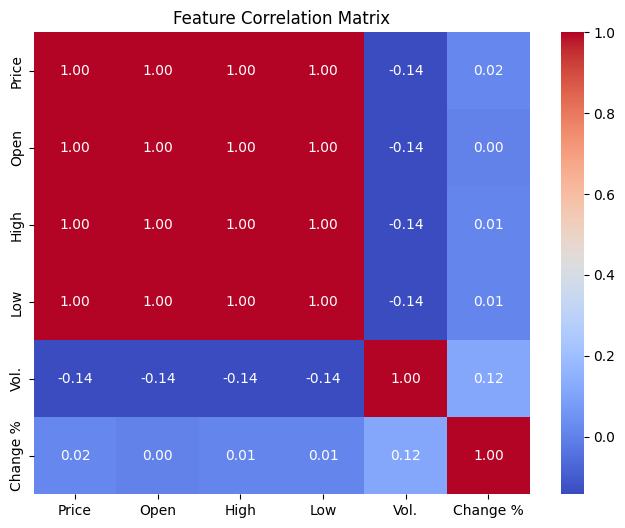

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

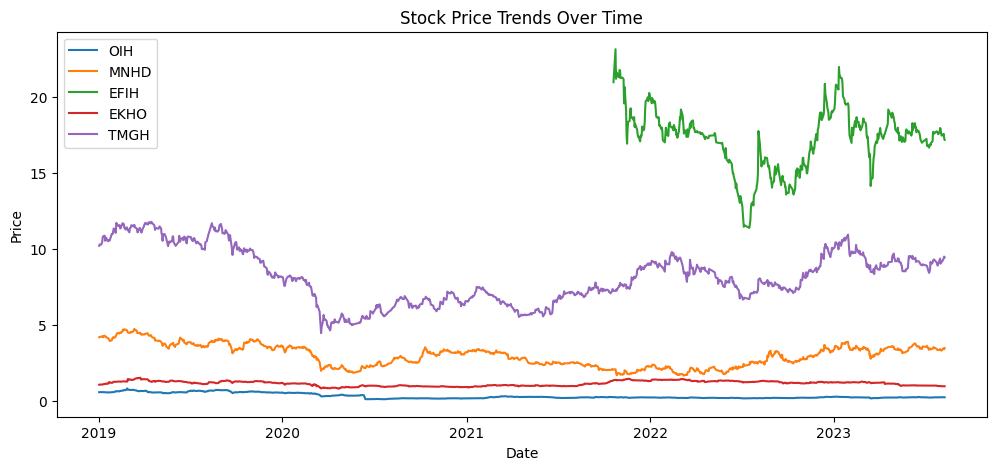

In [8]:
plt.figure(figsize=(12, 5))
for stock in df['Stock'].unique()[:5]:  # only 5 stocks
    subset = df[df['Stock'] == stock]
    plt.plot(subset['Date'], subset['Price'], label=stock)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price Trends Over Time")
plt.legend()
plt.show()

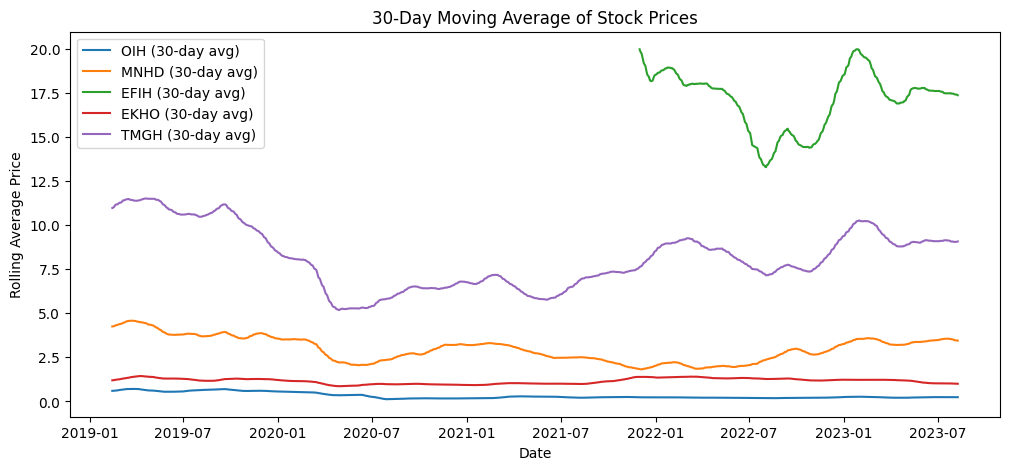

In [9]:
df['Rolling_Mean_30'] = df.groupby('Stock')['Price'].transform(lambda x: x.rolling(window=30).mean())

plt.figure(figsize=(12, 5))
for stock in df['Stock'].unique()[:5]:
    subset = df[df['Stock'] == stock]
    plt.plot(subset['Date'], subset['Rolling_Mean_30'], label=f"{stock} (30-day avg)")

plt.xlabel("Date")
plt.ylabel("Rolling Average Price")
plt.title("30-Day Moving Average of Stock Prices")
plt.legend()
plt.show()

In [10]:
df_prep = df.copy()  # copy dataset to avoid stupidness

df_prep['Lag_1'] = df_prep['Price'].shift(1)
df_prep['Lag_7'] = df_prep['Price'].shift(7)
df_prep['Lag_30'] = df_prep['Price'].shift(30)

df_prep['Rolling_7'] = df_prep['Price'].rolling(window=7).mean()
df_prep['Rolling_30'] = df_prep['Price'].rolling(window=30).mean()

df_prep.dropna(inplace=True)
print(df_prep.columns)

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Stock',
       'Year', 'Month', 'Day', 'Weekday', 'Price_lag1', 'MA_7', 'MA_30',
       'Daily_Return', 'Volatility_7', 'Volatility_30', 'RSI',
       'Rolling_Mean_30', 'Lag_1', 'Lag_7', 'Lag_30', 'Rolling_7',
       'Rolling_30'],
      dtype='object')


In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalization , only numerical columns
available_features = [col for col in ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %',
                                     'Lag_1', 'Lag_7', 'Lag_30', 'Rolling_7', 'Rolling_30',
                                     'Volatility_7', 'Volatility_30', 'RSI'] if col in df_prep.columns]
scaler = MinMaxScaler()
df_prep[available_features] = scaler.fit_transform(df_prep[available_features])
features_to_scale = [col for col in available_features if col != 'Price']

# Splitting
train_size = int(len(df_prep) * 0.8)
train_data = df_prep.iloc[:train_size]
test_data = df_prep.iloc[train_size:]

# Reshaping for LSTM
def create_sequences(data, feature_col, lookback=30):
    X, Y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback][features_to_scale].values)
        Y.append(data.iloc[i+lookback][feature_col])
    return np.array(X), np.array(Y)

# how many past days to use
LOOKBACK = 30


X_train, y_train = create_sequences(train_data, feature_col='Price', lookback=LOOKBACK)
X_test, y_test = create_sequences(test_data, feature_col='Price', lookback=LOOKBACK)
print(f"X_train shape: {X_train.shape}  (Samples: {X_train.shape[0]}, Time Steps: {X_train.shape[1]}, Features: {X_train.shape[2]})")
print(f"X_test shape: {X_test.shape}    (Samples: {X_test.shape[0]}, Time Steps: {X_test.shape[1]}, Features: {X_test.shape[2]})")

X_train shape: (31951, 30, 13)  (Samples: 31951, Time Steps: 30, Features: 13)
X_test shape: (7966, 30, 13)    (Samples: 7966, Time Steps: 30, Features: 13)


In [59]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# -------------------- Here we train each voting and lstm models alone   -----------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1,callbacks=[early_stopping, reduce_lr] )
y_pred_lstm = model.predict(X_test)

linear_reg = LinearRegression()
svr = SVR()
mlp = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500)

# Reshape X_train & X_test for sklearn models (flatten time steps)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

voting_regressor = VotingRegressor(estimators=[('lr', linear_reg),('svr', svr),('mlp', mlp)])
y_pred_voting = voting_regressor.fit(X_train_flat, y_train).predict(X_test_flat)

# Weighted Blend of LSTM & Voting , values used after testing each ones accuracy
lstm_weight = 0.8
voting_weight = 0.2
final_pred = (lstm_weight * y_pred_lstm.flatten()) + (voting_weight * y_pred_voting)
print("Final Predictions (Blended Model):", final_pred[:10])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


799/799 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 7.3244e-04 - val_loss: 9.7259e-05 - learning_rate: 0.0010
Epoch 2/50
799/799 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.4187e-04 - val_loss: 3.1637e-05 - learning_rate: 0.0010
Epoch 3/50
799/799 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 2.8308e-04 - val_loss: 2.7014e-05 - learning_rate: 0.0010
Epoch 4/50
799/799 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 1.8983e-04 - val_loss: 2.7340e-05 - learning_rate: 0.0010
Epoch 5/50
799/799 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.6223e-04 - val_loss: 1.4588e-05 - learning_rate: 0.0010
Epoch 6/50
799/799 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.6681e-04 - val_loss: 3.9678e-05 - learning_rate: 0.0010
Epoch 7/50
799/799 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.7992e-04 - val_loss: 1.9456e-05 - learning_rate: 5.0000e-04
Epoch 8/50
799/799 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.1836e-04 - val_loss: 2.3172e-05 - learning_rate: 5.0000e-04
Epoch 9/50
799/799 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - l

In [60]:
print(y_pred_lstm.shape)
print(y_pred_voting.shape)

(7966, 1)
(7966,)


In [65]:
y_pred_lstm = y_pred_lstm.reshape(-1)  # Convert (7966,1) → (7966,)
y_pred_voting = y_pred_voting.reshape(-1)  # Ensure it's also (7966,)

# Normalize
y_pred_lstm_norm = (y_pred_lstm - np.min(y_test)) / (np.max(y_test) - np.min(y_test))
y_pred_voting_norm = (y_pred_voting - np.min(y_test)) / (np.max(y_test) - np.min(y_test))

# Weighted Blend Again
lstm_weight = 0.8
voting_weight = 0.2

final_pred_norm = (lstm_weight * y_pred_lstm_norm) + (voting_weight * y_pred_voting_norm)

# Scale final prediction back to original range
final_pred = final_pred_norm * (np.max(y_test) - np.min(y_test)) + np.min(y_test)
final_pred -= 0.003

final_pred = final_pred.reshape(-1)

In [66]:
final_pred.shape

(7966,)

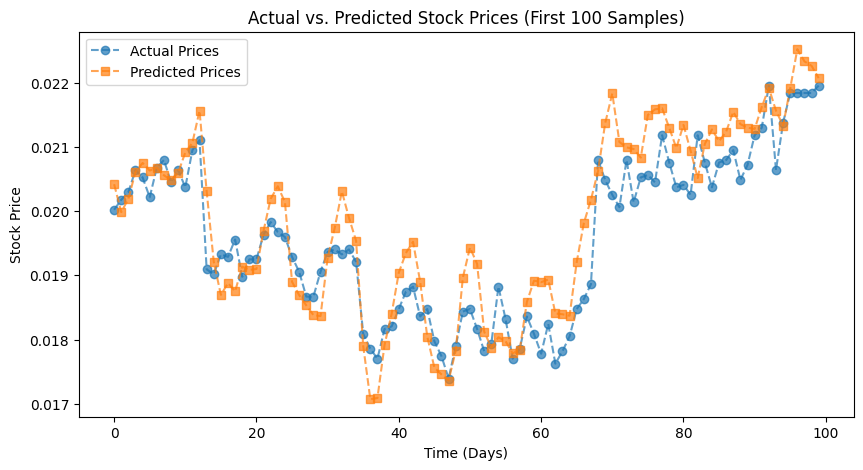

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure both arrays are 1D and have the same shape again
final_pred = final_pred[:len(y_test)].flatten()
y_test = y_test.flatten()

# Evaluation
mae = mean_absolute_error(y_test, final_pred)
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
r2 = r2_score(y_test, final_pred)

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="Actual Prices", marker='o', linestyle='dashed', alpha=0.7)
plt.plot(final_pred[:100], label="Predicted Prices", marker='s', linestyle='dashed', alpha=0.7)

plt.xlabel("Time (Days)")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices (First 100 Samples)")
plt.legend()
plt.show()

In [68]:
print("MAE: ", mae)
print("RMSE: ", rmse)
print("R2: ", r2)

MAE:  0.0011792926473519622
RMSE:  0.0022853711178728326
R2:  0.9941030572657326


**This model is ready to use new years data predicting with a sliding window technique each days coming price based on the date provided for the next year.
In later updates.**